In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import os
import pprint
import glob
from pathlib import Path
import pickle
import random

from tqdm.autonotebook import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import pandas as pd
import torch
from pytorch3d.io import save_obj
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    OpenGLPerspectiveCameras, 
    NormWeightedCompositor,
    look_at_view_transform,
    TexturesVertex,
    Textures,
    PointLights
)

from utils import general_utils
from utils import visualization_tools
from mesh_refiner import MeshRefiner
from utils.evaluation import evaluate

In [12]:
device = torch.device("cuda:0")
cfg = general_utils.load_config("config.yaml")

instances = {}
instances["f390b1b28b6dda03dc57b3e43c28d486"] = {"input_img_path": "data/examples/f390b1b28b6dda03dc57b3e43c28d486.png", "original_mesh_path":"data/examples/f390b1b28b6dda03dc57b3e43c28d486.obj", "gt_mesh_path": "data/ground_truth/f390b1b28b6dda03dc57b3e43c28d486.obj", "azim":150, "elev":40, "dist":1.2}
instances["eb8fe6d82d195ab5bc8feea465aa74f2"] = {"input_img_path": "data/examples/eb8fe6d82d195ab5bc8feea465aa74f2.png", "original_mesh_path":"data/examples/eb8fe6d82d195ab5bc8feea465aa74f2.obj", "gt_mesh_path": "data/ground_truth/eb8fe6d82d195ab5bc8feea465aa74f2.obj", "azim":336, "elev":40, "dist":1.2}
instances["f6b96f56212f55363023a5c0cae3fffe"] = {"input_img_path": "data/examples/f6b96f56212f55363023a5c0cae3fffe.png", "original_mesh_path":"data/examples/f6b96f56212f55363023a5c0cae3fffe.obj", "gt_mesh_path": "data/ground_truth/f6b96f56212f55363023a5c0cae3fffe.obj", "azim":323, "elev":40, "dist":1.3}
instances["0146"] = {"input_img_path": "data/examples/0146.png", "original_mesh_path":"data/examples/0146.obj", "gt_mesh_path": "data/ground_truth/0146.obj", "azim":69, "elev":22, "dist":1.1}
instances["OWILD_White_Toy_Rv_090"] = {"input_img_path": "data/examples/OWILD_White_Toy_Rv_090.png", "original_mesh_path":"data/examples/OWILD_White_Toy_Rv_090.obj", "gt_mesh_path": "data/ground_truth/White_Toy_Rv.obj", "azim":175, "elev":6, "dist":1}
instances["OOWL_Alta_Dena_Whipped_Cream_Can_090"] = {"input_img_path": "data/examples/OOWL_Alta_Dena_Whipped_Cream_Can_090.png", "original_mesh_path":"data/examples/OOWL_Alta_Dena_Whipped_Cream_Can_090.obj", "gt_mesh_path": "data/ground_truth/Alta_Dena_Whipped_Cream_Can.obj", "azim":189, "elev":8, "dist":1}

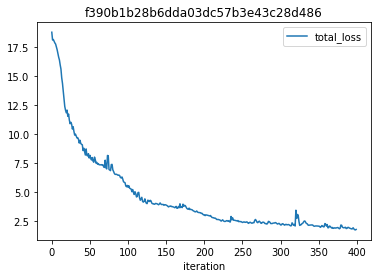

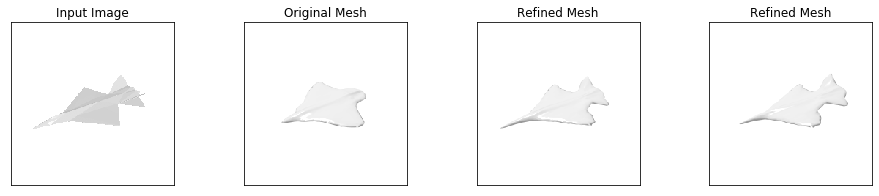

In [ ]:
for instance_name in instances:
    # setting up
    input_img_path = instances[instance_name]["input_img_path"]
    original_mesh_path = instances[instance_name]["original_mesh_path"]
    azim = instances[instance_name]["azim"]
    elev = instances[instance_name]["elev"]
    dist = instances[instance_name]["dist"]
    input_image = np.asarray(Image.open(input_img_path))
    with torch.no_grad():
        input_mesh = general_utils.load_untextured_mesh(original_mesh_path, device)
    R, T = look_at_view_transform(dist, elev, azim)
    
    # performing REFINE
    mesh_refiner = MeshRefiner(cfg, device)
    refined_mesh, refinement_info = mesh_refiner.refine_mesh(input_mesh, input_image, R, T, record_debug=True)
    
    # plotting loss, visualizing results, and saving refined mesh
    refined_mesh_path = os.path.join("data/REFINEd_output", "{}_refined.obj".format(instance_name))
    save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
    refined_mesh = general_utils.load_untextured_mesh(refined_mesh_path, device)
    refinement_info["loss_info"].plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
    visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, R, T, device, num_novel_view=1)
    
    # evaluation
    #gt_mesh_path = instances[instance_name]["gt_mesh_path"]
    #metrics_before = evaluate(original_mesh_path, gt_mesh_path, device)
    #metrics_after = evaluate(refined_mesh_path, gt_mesh_path, device)
    #for metric in metrics_before:
    #    print("{}: {} -> {}".format(metric, metrics_before[metric], metrics_after[metric]))
    